In [0]:
#Importing Libraries
import pandas as pd #pandas to create small dataframes
import numpy as np #Do aritmetic operations on arrays

import os
from datetime import datetime
import pickle

# Visualization related packages
import matplotlib.pylab as plt
import seaborn as sns #Plots
sns.set()

# model related packages
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Evaluation metric related packages
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import OneHotEncoder
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# packages for presenting the results
from  prettytable import  PrettyTable

from tsfresh.feature_extraction import feature_calculators

# Configs

In [0]:
print(datetime.now() ,' Started')
base_dir = './data'
kmeans_path = './model/NYC_kmeans_model.pickle'
test_size = 0.3 # train, test partitioning threshold

# set sample size here for testing the code
sample_size = -1 # set -1 if we want to use full dataset

2019-06-28 09:18:17.825627  Started


# UTIL Functions 

In [0]:
def compute_mape(actual, predicted):

    # compute MAPE error
    try:
        mape = mean_absolute_error(actual, predicted) / np.mean(actual) * 100.0
        mape = round(mape, 4)
    except ZeroDivisionError:
        print('Division by zero error in MAPE')
        mape = np.inf
    except:
        print('Exception in computing MAPE value')
        mape = np.inf
        
    return mape

In [0]:
def evaluate_model(actual_values_list, predicted_values_list):
    
    # get MSE, MAPE error metrics
    mse = round(mean_squared_error(actual_values_list, predicted_values_list), 4)
    mape = round(compute_mape(actual_values_list, predicted_values_list), 4)
    
    return (mse, mape,)

# Data

### 2015 Data 

In [0]:
# Read Jan, Feb & March data
df_jan_2015 = pd.read_csv(os.path.join(base_dir, 'ts_data_jan_2015.csv'), index_col=False)
df_feb_2015 = pd.read_csv(os.path.join(base_dir, 'ts_data_feb_2015.csv'), index_col=False)
df_mar_2015 = pd.read_csv(os.path.join(base_dir, 'ts_data_mar_2015.csv'), index_col=False)

shape_info = df_jan_2015.shape + df_feb_2015.shape + df_mar_2015.shape

print('Shape of data frames Jan:(%d,%d), Feb:(%d,%d) & March:(%d,%d)'%shape_info)

# concatenate three months data
df_2015 = pd.concat([df_jan_2015, df_feb_2015, df_mar_2015], axis=1)
df_2015.columns = range(0, df_2015.shape[1])
print(df_2015.shape)
df_2015.head()

Shape of data frames Jan:(30,4464), Feb:(30,4032) & March:(30,4464)
(30, 12960)


,0,1,2,3,4,5,6,7,8,9,...,12950,12951,12952,12953,12954,12955,12956,12957,12958,12959
0,15,15,114,141,144,200,145,184,190,225,...,60.0,52.0,48.0,66.0,54.0,36.0,68.0,46.0,29.0,18.0
1,54,54,228,266,248,262,278,270,314,275,...,116.0,163.0,79.0,132.0,116.0,120.0,125.0,149.0,119.0,118.0
2,15,15,47,42,47,21,15,33,16,27,...,87.0,71.0,90.0,98.0,76.0,55.0,98.0,72.0,40.0,67.0
3,18,18,26,18,14,5,13,19,7,16,...,87.0,104.0,139.0,84.0,86.0,68.0,79.0,61.0,50.0,42.0
4,58,58,240,220,157,145,130,189,149,133,...,178.0,174.0,214.0,208.0,118.0,166.0,164.0,185.0,135.0,135.0


### 2016 Data 

In [0]:
# Read Jan, Feb & March data
df_jan_2016 = pd.read_csv(os.path.join(base_dir, 'ts_data_jan_2016.csv'), index_col=False)
df_feb_2016 = pd.read_csv(os.path.join(base_dir, 'ts_data_feb_2016.csv'), index_col=False)
df_mar_2016 = pd.read_csv(os.path.join(base_dir, 'ts_data_mar_2016.csv'), index_col=False)

shape_info = df_jan_2016.shape + df_feb_2016.shape + df_mar_2016.shape

print('Shape of data frames Jan:(%d,%d), Feb:(%d,%d) & March:(%d,%d)'%shape_info)

# concatenate three months data
df_2016 = pd.concat([df_jan_2016, df_feb_2016, df_mar_2016], axis=1)
df_2016.columns = range(0,df_2016.shape[1])
print(df_2016.shape)
df_2016.head()

Shape of data frames Jan:(30,4464), Feb:(30,4176) & March:(30,4464)
(30, 13104)


,0,1,2,3,4,5,6,7,8,9,...,13094,13095,13096,13097,13098,13099,13100,13101,13102,13103
0,0,32,110,145,160,176,157,155,156,161,...,92,96,92,74,59,88,76,76,73,65
1,0,96,204,228,257,222,228,268,260,236,...,193,163,171,165,170,178,180,166,132,155
2,0,28,27,37,21,22,18,27,17,15,...,76,94,93,92,74,80,67,51,63,66
3,0,9,33,16,8,11,4,8,11,20,...,133,123,135,139,137,131,127,148,84,94
4,0,79,171,168,125,163,138,172,153,135,...,160,187,164,171,176,194,190,160,168,144


%%HTML
<ul>
<li> 2016 is a leap year and FEB has 29 days</li>
<li> We can discard the last day of March 2016 to make the dataset sizes equal </li>
</ul>

In [0]:
num_days = min(df_2015.shape[1], df_2016.shape[1])
df_2015 = df_2015.iloc[:,0:num_days]
df_2016 = df_2016.iloc[:,0:num_days]
print('Shape of DF 2015: ', df_2015.shape, 'Shape of DF 2016: ',df_2016.shape)

Shape of DF 2015:  (30, 12960) Shape of DF 2016:  (30, 12960)


In [0]:
print('Minimum pickup value in df_2015 DF', df_2015.min().min())
print('Minimum pickup value in df_2016 DF', df_2016.min().min())

Minimum pickup value in df_2015 DF 1.0
Minimum pickup value in df_2016 DF 0


In [0]:
print('Maximum pickup value in df_2015 DF', df_2015.max().max())
print('Maximum pickup value in df_2016 DF', df_2016.max().max())

Maximum pickup value in df_2015 DF 681.0
Maximum pickup value in df_2016 DF 645


# A) Time Series Baseline Models 

### Train, Test Split & Optional Sample Data

In [0]:
if sample_size > 0:
    print('Sample is taken !!!')
    # sample of 
    df_2015 = df_2015.iloc[0:sample_size, :]
    df_2016 = df_2016.iloc[0:sample_size, :]
    
# train test split

# partition data to train, test
split_point = int((1-test_size) * df_2016.shape[1])
print('Split point :', split_point)

# split to train & test data (2015)
df_2015_train = df_2015.iloc[:, 0:split_point]
df_2015_train.columns = range(0, df_2015_train.shape[1])
df_2015_test = df_2015.iloc[:, split_point:]
df_2015_test.columns = range(0, df_2015_test.shape[1])
print('Data Frmae 2015 train shapes :', df_2015_train.shape,)
print('Data Frmae 2015 test shapes :', df_2015_test.shape,)

# split to train & test data (2016)
df_2016_train = df_2016.iloc[:, 0:split_point]
df_2016_train.columns = range(0, df_2016_train.shape[1])
df_2016_test = df_2016.iloc[:, split_point:]
df_2016_test.columns = range(0, df_2016_test.shape[1])
print('Data Frmae 2016 train shapes :', df_2016_train.shape,)
print('Data Frmae 2016 test shapes :', df_2016_test.shape,)

print('\n'*2)

####### Preparing ratio DF
ratio_df_train = df_2016_train / df_2015_train
# replace 0/0 with 1.0
print('Any invalid entry in the ratio df train:', 
      ratio_df_train.isin([np.inf, -np.inf, None]).any().any())
ratio_df_train = ratio_df_train.fillna(0.0)


ratio_df_test = df_2016_test / df_2015_test
# replace 0/0 with 1.0
print('Any inf entry in the ratio df test:', 
      ratio_df_test.isin([np.inf, -np.inf, None]).any().any())
ratio_df_test = ratio_df_test.fillna(0.0)

print('Ratio DF Train data frame size :', ratio_df_train.shape)
print('Ratio DF Test data frame size :', ratio_df_test.shape)

Split point : 9072
Data Frmae 2015 train shapes : (30, 9072)
Data Frmae 2015 test shapes : (30, 3888)
Data Frmae 2016 train shapes : (30, 9072)
Data Frmae 2016 test shapes : (30, 3888)



Any invalid entry in the ratio df train: False
Any inf entry in the ratio df test: False
Ratio DF Train data frame size : (30, 9072)
Ratio DF Test data frame size : (30, 3888)


## Baseline Model Functions

In [0]:
def Simple_MA_Prediction(value_array, window_size):
    
    # if size less than 2 return as it is
    if len(value_array) < 2:
        return value_array
    
    # initialize predicted value list as empty
    predicted_values = list()
    
    # # process each element in the value list
    for index, value in enumerate(value_array):
        
       # case 1: We have already made atleast window_size predictions
        if index >=  window_size:
            predicted_value = np.mean(value_array[index - window_size : index])
            
        # case 2: We have just started prediction
        else:
            if index == 0:
                predicted_value = value
            else:
                predicted_value = np.mean(value_array[0 : index])
        
        # update the list
        predicted_values.append(predicted_value)
        
    # round the values to integers
    predicted_values = np.array([int(round(item)) for item in predicted_values])
        
        
    return np.array(predicted_values)   

In [0]:
def WMA_Predictions(value_array, window_size):
    
    # if size less than 2 return as it is
    if len(value_array) < 2:
        return value_array
    
    # set the denominator
    denominator = (( window_size) * ( window_size + 1)) / 2
    
    # weights array
    window_weight_array = np.array(range(1, window_size + 1)) / denominator
    
    # initialize the predicted value with first element of value list
    predicted_values = list()
    
    # process each element in the value list
    for index, val in enumerate(value_array):
        
        # case 1: we have already made atleast window_size predictions
        if index >=  window_size:
            predicted_value = np.mean(window_weight_array * value_array[index - window_size : index])
            
        # case 2: we have just started prediction
        else:
            
            if index == 0:
                predicted_value = val
            else:
                # set the denominator
                denominator = (index * (index + 1)) / 2
                # weights array
                temp_weight_array = np.array(range(1, index + 1)) / denominator

                predicted_value = np.mean(temp_weight_array * value_array[0 : index])
        
        # update the list
        predicted_values.append(predicted_value)
        
    # round the values to integers
    predicted_values = np.array([int(round(item)) for item in predicted_values])
        
    return predicted_values

In [0]:
def exp_weighted_MA_Predictions(value_array, alpha):
    
    # if size less than 2 return as it is
    if len(value_array) < 2:
        return value_array
    
    # initialize as empty
    predicted_values = list()
    
    # predict for every time step
    for index, value in enumerate(value_array):
        
        if index > 0:
            predicted = alpha * value_array[index-1] + (1-alpha) * predicted_values[-1]
        else:
            predicted = value_array[0]
         
        # update list
        predicted_values.append(predicted)
        
    # round the values to integers
    predicted_values = np.array([int(round(item)) for item in predicted_values])
        
    return predicted_values

In [0]:
def timeseries_model_prediction(df, window_size_sim, window_size_weight, alpha):
    
    # initialize three lists for saving three types of time series prediction
    simple_avg_prediction_list = list()
    weighted_avg_prediction_list = list()
    exp_weighted_avg_prediction_list = list()
    
    # predict one row at a time
    for index, row in df.iterrows():
        
        # get the row as numpy array
        inp_array = row.values
        
        # get simple moving average prediction
        simp_avg_pred = Simple_MA_Prediction(inp_array, window_size_sim)
        
        # get weighted moving average prediction
        weighted_avg_pred = WMA_Predictions(inp_array, window_size_weight)
        
        # get exponentially weighted moving average prediction
        exp_weighted_avg_pred = exp_weighted_MA_Predictions(inp_array, alpha)
            
        # update the lists
        simple_avg_prediction_list.append(simp_avg_pred)
        weighted_avg_prediction_list.append(weighted_avg_pred)
        exp_weighted_avg_prediction_list.append(exp_weighted_avg_pred)
        
    # prepare three types of prediction dfs
    simple_avg_prediction_df = pd.DataFrame(simple_avg_prediction_list)
    weighted_avg_prediction_df = pd.DataFrame(weighted_avg_prediction_list)
    exp_weighted_avg_prediction_df = pd.DataFrame(exp_weighted_avg_prediction_list)
    
    ret_tuple = (simple_avg_prediction_df, weighted_avg_prediction_df, 
                 exp_weighted_avg_prediction_df,)
    
    
    return ret_tuple

In [0]:
def find_best_hyperparam(df):
    
    print(datetime.now() ,' Hyperparam Tuning of time series model started')
    
    # try 10 different window sizes from 1 to 10
    window_size_list = list(range(1, 11))

    # try differnt alpah values from 0.3 to 0.99
    alpha_val_list = [0.20, 0.30, 0.40, 0.50, 0.65, 
                      0.75, 0.82, 0.90, 0.95, 0.99]
    
    hyp_info_list = list()

    # evaluate each hyp value
    for window_size, alpha in zip(window_size_list, alpha_val_list):
        
        # predict using this hyperparam
        pred_dfs = timeseries_model_prediction(df, window_size, window_size, alpha)
        # separate out the prediction dfs
        smp_pred_df, weight_pred_df, exp_pred_df = pred_dfs
        
        # get actual values list
        actual_values_list = df.values.flatten()
        
        # get predicted values list
        predicted_values_list_sma = smp_pred_df.values.flatten()
        predicted_values_list_wma = weight_pred_df.values.flatten()
        predicted_values_list_exp = exp_pred_df.values.flatten()
        
        # evaluate three models on this hyperparam
        sim_mse, sim_mape = evaluate_model(actual_values_list, predicted_values_list_sma)
        wm_mse, wm_mape = evaluate_model(actual_values_list, predicted_values_list_wma)
        exp_mse, exp_mape = evaluate_model(actual_values_list, predicted_values_list_exp)
        
        # update hyp info list
        hyp_info_list.append((window_size, alpha, sim_mse, sim_mape,
                             wm_mse, wm_mape, exp_mse, exp_mape,))
        
    # create the evaluation df
    eval_df = pd.DataFrame(hyp_info_list, columns=['Window', 'Alpha', 'SIM_MSE', 
                                                   'SIM_MAPE', 'WM_MSE', 'WM_MAPE',
                                                   'EXP_MSE', 'EXP_MAPE'])
    
    # best index
    sim_model_best_index = eval_df['SIM_MAPE'].idxmin()
    weight_model_best_index = eval_df['WM_MAPE'].idxmin()
    exp_model_best_index = eval_df['EXP_MAPE'].idxmin()
    
    print("""Hyper params (Window  for simple, weighted MA,
             Alpha for Exponentailly weighted model) scores df: \n\n\n""", eval_df)
    
    # get the best hyperparam based on the MAPE lowest value
    sim_best_window = eval_df.loc[sim_model_best_index, 'Window']
    weight_best_window = eval_df.loc[weight_model_best_index, 'Window']
    exp_best_alpha = eval_df.loc[exp_model_best_index, 'Alpha']
    
    print('\n'*2)
    
    print('Best Window Size (Hyperparam) for Simple Moiving Average: ', sim_best_window)
    print('Best Window Size (Hyperparam) for Weighted Moiving Average: ', weight_best_window)
    print('Best Alpha (Hyperparam) for Exp. Weighted Moiving Average: ', exp_best_alpha)
    
    
    best_mse_sim = eval_df.loc[sim_model_best_index, 'SIM_MSE']
    best_mape_sim = eval_df.loc[sim_model_best_index, 'SIM_MAPE']

    best_mse_wma = eval_df.loc[weight_model_best_index, 'WM_MSE']
    best_mape_wma = eval_df.loc[weight_model_best_index, 'WM_MAPE']
    
    best_mse_ewma = eval_df.loc[exp_model_best_index, 'EXP_MSE']
    best_mape_ewma = eval_df.loc[exp_model_best_index, 'EXP_MAPE']
    
    
    print('\n'*2)
    print('Simple Moiving Average : Best MSE : %f, MAPE : %f'%(best_mse_sim, 
                                                               best_mape_sim,))
    print('Weighted Moiving Average : Best MSE : %f, MAPE : %f'%(best_mse_wma, 
                                                                 best_mape_wma,))
    print('Exp. Weighted Moiving Average : Best MSE :%f MAPE : %f'%(best_mse_ewma, 
                                                                    best_mape_ewma,))
    
    # prepare a return tuple
    ret_tuple = (sim_best_window, weight_best_window, exp_best_alpha,)
    
    print(datetime.now() ,' Hyperparam Tuning of time series model completed')

    return ret_tuple

In [0]:
def evaluate_time_series_model(actual_df, pred_smp_df, pred_weight_df, pred_exp_df):
    
    # get actual values list
    actual_values_list = actual_df.values.flatten()

    # get predicted values list
    predicted_values_list_sma = pred_smp_df.values.flatten()
    predicted_values_list_wma = pred_weight_df.values.flatten()
    predicted_values_list_exp = pred_exp_df.values.flatten()
    
    # evaluate three models on this hyperparam
    sim_mse, sim_mape = evaluate_model(actual_values_list, 
                                       predicted_values_list_sma)
    wm_mse, wm_mape = evaluate_model(actual_values_list, 
                                     predicted_values_list_wma)
    exp_mse, exp_mape = evaluate_model(actual_values_list, 
                                       predicted_values_list_exp)
    # prepare evaluation dict
    eval_dict = {
         # MSE values
        'SMA_MSE' : sim_mse,
        'WMA_MSE' : wm_mse,
        'EWMA_MSE' : exp_mse,
        # MAPE values
        'SMA_MAPE' : sim_mape,
        'WMA_MAPE' : wm_mape,
        'EWMA_MAPE' : exp_mape   
    }
    
    return eval_dict

##  A1) Using Ratios  $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$

In [0]:
ratio_df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887
0,0.918919,0.937500,0.666667,0.785714,0.896552,1.400000,1.250000,0.458333,1.034483,1.650000,...,1.316667,1.634615,1.645833,1.136364,1.444444,1.888889,0.926471,1.304348,1.862069,4.166667
1,1.381443,1.200000,1.153846,1.103448,1.352941,1.388060,1.628571,1.064516,1.120000,1.564103,...,1.172414,0.846626,1.443038,1.007576,0.939655,1.133333,1.072000,0.892617,1.168067,0.949153
2,2.500000,1.333333,0.490566,1.000000,2.285714,2.285714,1.692308,0.615385,0.321429,1.857143,...,0.678161,0.633803,0.744444,0.581633,0.921053,1.345455,0.500000,1.000000,2.050000,1.134328
3,1.380000,3.181818,2.909091,2.777778,6.666667,2.000000,22.000000,0.950000,0.900000,0.368421,...,0.965517,1.125000,0.762590,1.011905,1.523256,1.235294,0.822785,1.475410,1.780000,2.047619
4,1.021277,0.798817,0.964286,0.967213,0.980583,0.641221,0.714286,1.582090,0.972222,1.509434,...,0.988764,1.040230,1.014019,1.322115,1.949153,1.234940,1.079268,0.859459,1.200000,0.762963


### Hyperparam Tuning

In [0]:
ratio_sim_best_window, ratio_weight_best_window, ratio_exp_best_alpha = find_best_hyperparam(
                                                                                ratio_df_train)

2019-06-28 09:18:22.315545  Hyperparam Tuning of time series model started
Hyper params (Window  for simple, weighted MA,
             Alpha for Exponentailly weighted model) scores df: 


    Window  Alpha  SIM_MSE  SIM_MAPE   WM_MSE  WM_MAPE  EXP_MSE  EXP_MAPE
0       1   0.20   6.5143   47.7601   6.5143  47.7601   7.0056   45.2637
1       2   0.30   5.4129   44.4276   8.8089  66.8213   5.9773   43.5184
2       3   0.40   5.6812   43.7967  12.4398  84.9637   5.5158   42.9690
3       4   0.50   6.0661   43.8863  14.6630  90.5195   5.3420   42.9912
4       5   0.65   6.4733   44.3360  16.1249  93.3025   5.3802   43.6035
5       6   0.75   6.9351   44.8940  17.1457  94.9292   5.5640   44.3738
6       7   0.82   7.4280   45.5729  17.9066  95.9783   5.7494   45.0628
7       8   0.90   7.9085   46.3034  18.4868  96.7125   6.0369   46.0449
8       9   0.95   8.4264   47.0546  18.9336  97.2223   6.2598   46.7577
9      10   0.99   8.9056   47.7594  19.3055  97.6055   6.4473   47.2528



Best

## Evaluation of Ratio Model

### Train Metrics 

In [0]:
# predict using this hyperparam
ratio_pred_dfs_train = timeseries_model_prediction(ratio_df_train, ratio_sim_best_window, 
                                             ratio_weight_best_window, 
                                             ratio_exp_best_alpha)
# separate out the prediction dfs
ratio_smp_pred_df_train, ratio_weight_pred_df_train, ratio_exp_pred_df_train = ratio_pred_dfs_train


ratio_smp_pred_df_train = ratio_smp_pred_df_train * df_2015_train
ratio_weight_pred_df_train = ratio_weight_pred_df_train * df_2015_train
ratio_exp_pred_df_train = ratio_exp_pred_df_train * df_2015_train


# evaluate the model on train data
ratio_df_train_metrics = evaluate_time_series_model(df_2016_train, ratio_smp_pred_df_train, 
                                                    ratio_weight_pred_df_train, 
                                                    ratio_exp_pred_df_train)

### Test Metrics

In [0]:
# predict using this hyperparam
ratio_pred_dfs_test = timeseries_model_prediction(ratio_df_test, ratio_sim_best_window, 
                                             ratio_weight_best_window, 
                                             ratio_exp_best_alpha)
# separate out the prediction dfs
ratio_smp_pred_df_test, ratio_weight_pred_df_test, ratio_exp_pred_df_test = ratio_pred_dfs_test

# evaluate the model on train data
ratio_df_test_metrics = evaluate_time_series_model(df_2016_test, ratio_smp_pred_df_test, 
                                                   ratio_weight_pred_df_test, 
                                                   ratio_exp_pred_df_test)

## A2) Using Previous known values of the 2016 data itself 

In [0]:
sim_best_window, weight_best_window, exp_best_alpha = find_best_hyperparam(df_2016_train)

2019-06-28 09:19:58.704801  Hyperparam Tuning of time series model started
Hyper params (Window  for simple, weighted MA,
             Alpha for Exponentailly weighted model) scores df: 


    Window  Alpha   SIM_MSE  SIM_MAPE      WM_MSE  WM_MAPE   EXP_MSE  EXP_MAPE
0       1   0.20  421.1594   16.7887    421.1594  16.7887  609.8640   19.6173
1       2   0.30  379.2613   15.7021   3589.7023  50.3120  455.6465   17.0309
2       3   0.40  392.7172   15.8279   6161.7630  66.7591  395.1580   15.9382
3       4   0.50  423.9537   16.3720   7730.7172  75.0534  370.3592   15.4983
4       5   0.65  463.3412   17.0727   8762.2141  80.0363  363.6265   15.4484
5       6   0.75  509.8245   17.8712   9487.7430  83.3626  371.0461   15.6574
6       7   0.82  565.9459   18.7794  10024.1881  85.7366  380.6469   15.8919
7       8   0.90  628.9225   19.7483  10436.9915  87.5192  395.7816   16.2411
8       9   0.95  695.9107   20.7299  10764.0964  88.9051  407.6173   16.5077
9      10   0.99  766.0381   2

## Evaluation of 2016 Data Model

### Train Metrics 

In [0]:
# predict using this hyperparam
pred_dfs_2016_train = timeseries_model_prediction(df_2016_train, sim_best_window, 
                                                  weight_best_window, 
                                                  exp_best_alpha)
# separate out the prediction dfs
smp_pred_df_train, weight_pred_df_train, exp_pred_df_train = pred_dfs_2016_train

# evaluate the model on train data
df_2016_train_metrics = evaluate_time_series_model(df_2016_train, smp_pred_df_train, 
                                                   weight_pred_df_train, 
                                                   exp_pred_df_train)

### Test Metrics

In [0]:
# predict using this hyperparam
pred_dfs_2016_test = timeseries_model_prediction(df_2016_test, sim_best_window, 
                                                 weight_best_window, 
                                                 exp_best_alpha)
# separate out the prediction dfs
smp_pred_df_test, weight_pred_df_test, exp_pred_df_test = pred_dfs_2016_test

# evaluate the model on test data
df_2016_test_metrics = evaluate_time_series_model(df_2016_test, smp_pred_df_test, 
                                                  weight_pred_df_test, 
                                                  exp_pred_df_test)

# B) ML Regression Models

### 2016 Data 

In [0]:
# Read Jan, Feb & March data
df_jan_2016 = pd.read_csv(os.path.join(base_dir, 'ts_data_jan_2016.csv'), index_col=False)
df_feb_2016 = pd.read_csv(os.path.join(base_dir, 'ts_data_feb_2016.csv'), index_col=False)
df_mar_2016 = pd.read_csv(os.path.join(base_dir, 'ts_data_mar_2016.csv'), index_col=False)

shape_info = df_jan_2016.shape + df_feb_2016.shape + df_mar_2016.shape

print('Shape of data frames Jan:(%d,%d), Feb:(%d,%d) & March:(%d,%d)'%shape_info)

# concatenate three months data
df_2016 = pd.concat([df_jan_2016, df_feb_2016, df_mar_2016], axis=1)
df_2016.columns = range(0,df_2016.shape[1])
df_2016 = df_2016.iloc[:,0:num_days]

print(df_2016.shape)
df_2016.head()

Shape of data frames Jan:(30,4464), Feb:(30,4176) & March:(30,4464)
(30, 12960)


,0,1,2,3,4,5,6,7,8,9,...,12950,12951,12952,12953,12954,12955,12956,12957,12958,12959
0,0,32,110,145,160,176,157,155,156,161,...,79,85,79,75,78,68,63,60,54,75
1,0,96,204,228,257,222,228,268,260,236,...,136,138,114,133,109,136,134,133,139,112
2,0,28,27,37,21,22,18,27,17,15,...,59,45,67,57,70,74,49,72,82,76
3,0,9,33,16,8,11,4,8,11,20,...,84,117,106,85,131,84,65,90,89,86
4,0,79,171,168,125,163,138,172,153,135,...,176,181,217,275,230,205,177,159,162,103


In [0]:
print('Minimum pickup value in df_2015 DF', df_2015.min().min())
print('Maximum pickup value in df_2016 DF', df_2016.max().max())

Minimum pickup value in df_2015 DF 1.0
Maximum pickup value in df_2016 DF 645


In [0]:
def plot_timeseries_data_2016(row, region_id):
    
    print('Total number of time bins (3 Monts) :', len(row))
    
    jan_last_index = 4464
    feb_last_index = 8640 # adjust this according to leap year or not
    
    first_x = list(range(0, jan_last_index))
    second_x = list(range(jan_last_index, feb_last_index))
    third_x = list(range(feb_last_index, len(row)))

    plt.figure(figsize=(10,4))
    plt.plot(first_x,row[0:jan_last_index], color='g', 
             label='2016 Jan Pickups')
    plt.plot(second_x,row[jan_last_index:feb_last_index], color='b', 
             label='2016 Feb Pickups ')
    plt.plot(third_x,row[feb_last_index:], color='y',
             label='2016 March Pickups')
    plt.legend()
    plt.xlabel('Time Bin')
    plt.ylabel('Number of pickups')
    plt.title('Time Series Data of region : %d'%(region_id,))
    plt.show()

### Plot the time series info of some regions

Total number of time bins (3 Monts) : 12960


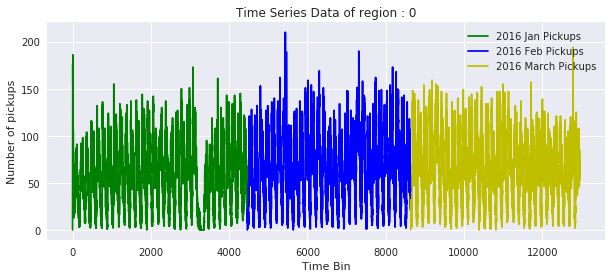

Total number of time bins (3 Monts) : 12960


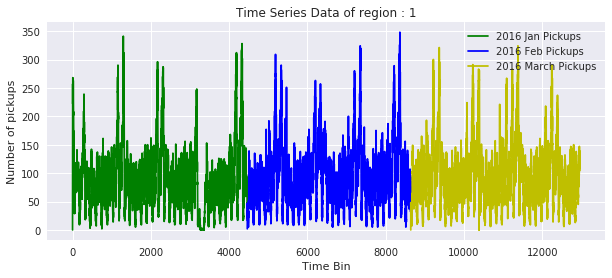

Total number of time bins (3 Monts) : 12960


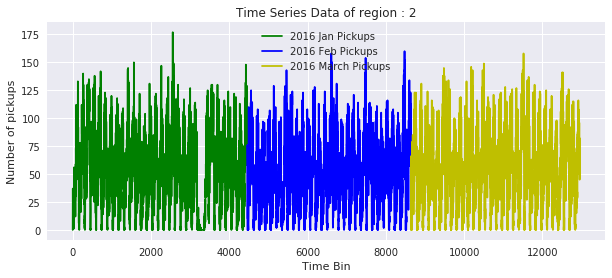

In [0]:
for region_id, row in df_2016.iloc[0:3,:].iterrows():
    
    # get number of pickus as a list
    pickup_count_list = list(row)
    # plot the time series information
    plot_timeseries_data_2016(pickup_count_list, region_id)

### Plot Fourier features

In [0]:
def plot_fft(row, region_id):

    # get frequency & amplitude
    amplitude    = np.fft.fft(np.array(row))
    freq = np.fft.fftfreq(len(row), 1)
    n = len(freq)
    
    # plot amplitude against frequency
    plt.figure()
    plt.plot(freq[:int(n/2)], np.abs(amplitude)[:int(n/2)] )
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('Fourier Features Region: %d'%(region_id,))
    plt.show()

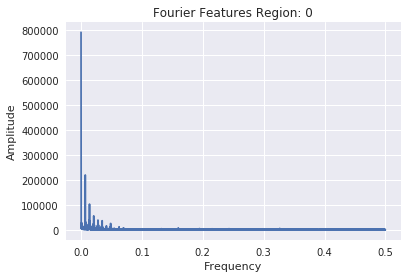

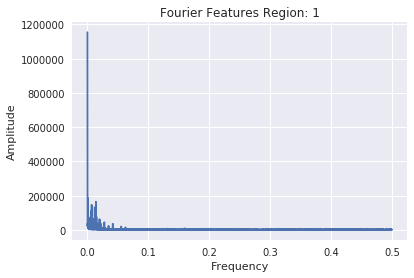

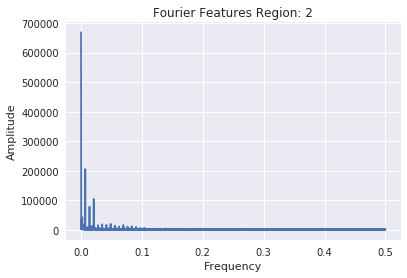

In [0]:
for region_id, row in df_2016.iloc[0:3,:].iterrows():
    plot_fft(list(row), region_id)

<h3> Observations </h3>
<ul>
<li> There are many peaks in the fourier series plot</li>
<li> Each peak represnts a repeation of pattern </li>
<li> The largest peak corresponds to the dc component </li>
<li> The first smallest represents the daily patten (1/144 time slots a day) </li>
<li> There are other peaks which coresponds to other pattens with in the day such a evening morning 
     pattern repeatations etc.</li>
<li> The above information can be incorporated into the model to improve the MAPE</li>
</ul>

### Box plot information of pickups

In [0]:
def boxplot_of_pickups(pickup_vals, reg_id):
    sns.boxplot(data=pickup_vals)
    plt.ylabel('Number of Pickups')
    plt.xlabel('Region %d'%(reg_id,))
    plt.title('Quantile information of Region')
    plt.xticks(list())
    plt.show()

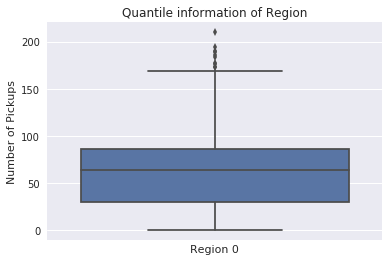

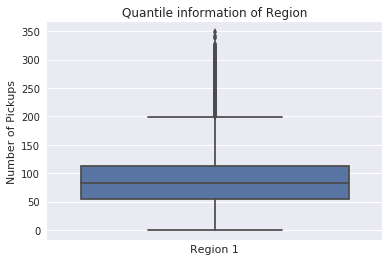

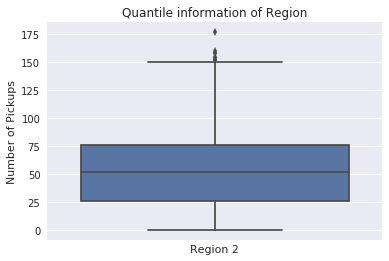

In [0]:
for region_id, row in df_2016.iloc[0:3,:].iterrows():
    boxplot_of_pickups(list(row), region_id)

In [0]:
def get_timeseries_engineered_features(past_pickup_info):
    """
    This function takes a time series data of number of pickups of a region.
    It computes the fourier features such as centroid & variance It also computes 
    the count features of past pickup data.
    """
    
    # pack the top 3 featrues
    # count features
    count_above = feature_calculators.count_above_mean(past_pickup_info)
    count_below = feature_calculators.count_below_mean(past_pickup_info)
    
    eng_features = [count_above, count_below]

    return eng_features

In [0]:
def get_fourier_features(ts_list, num_features):
    
    # compute amplitude & frequency
    amplitude = abs(np.fft.fft(ts_list))
    frequency = abs(np.fft.fftfreq(len(ts_list), 1))
    
    # create the fourier df
    fourier_df = pd.DataFrame({'Amplitude':amplitude,
                               'Freq':frequency}, 
                              index=range(len(amplitude)))
    
    # sort based on amlitude value in descending order
    fourier_df = fourier_df.sort_values(['Amplitude'], 
                                        ascending=False)
    fourier_df = fourier_df.reset_index(drop=True)
    
    requied_indices = list(range(0, 2*num_features-1, 2))
    
    fourier_df = fourier_df.iloc[requied_indices, :]
    
    # returns in the order of amplitudesm, frequencies.
    amp_feats = fourier_df['Amplitude'].tolist()
    freq_feats = fourier_df['Freq'].tolist()
    
    fourier_feats = amp_feats + freq_feats
    
    return fourier_feats

## Prpare dataset for ML Models

In [0]:
def get_final_dataframe(df, kmeans_path, window_size, alpha):
    
    # set the number of fourier features required
    num_fourier_feat = 5
    
    print('Shape of input data frame', df.shape)
    
    if os.path.exists('./data/Final_NYC_ML_Data_Frame.csv'):
        # try to read the file
        print('Final data frame already exists in the location !!!')
        final_df = pd.read_csv('./data/Final_NYC_ML_Data_Frame.csv', 
                               index_col=False)
        
        # return the existing file
        return final_df
    
    # load the kmeans model
    kmeans_model_file = open(kmeans_path, 'rb')
    kmeans = pickle.load(kmeans_model_file)
    kmeans_model_file.close()
    
    # create a one hot encoder for preparing a day list
    day_encoded = np.array(range(0,7)).reshape(7, 1)
    one_hot_encoder = OneHotEncoder(sparse=False, categorical_features='all')
    one_hot_encoder.fit(day_encoded)

    # one-hot encode the days
    one_hot_encoded = one_hot_encoder.transform(day_encoded)
    # create a dictionary of one-hot encoded representation
    week_info_dict = {index : list(one_hot_encoded[index]) for 
                      index in range(0,7)}
    
    # get total columns in the data frame
    total_cols =  df.shape[1]
    
    # prepare a day list which contains the day number of the bin number
    day_list = list()
    
    for index in range(1, total_cols + 1):
        week_day = ((math.ceil(index/144)) % 7 )
        day_list.append(week_day)
          
    # add features by traversing row by row
    final_data_list = list()
    
    #for extracting fourier & other features
    num_slots_back = 30 # we look back past 5 hours
    
    for region_id, row in df.iterrows():
        
        # get the row representation oc current region
        current_row = list(row)
        
        # feature set 1 : get lat, long values for this region
        lat_long = list(kmeans.cluster_centers_[region_id])
        
        # compute the fourier features (top 5 amplitudes & its freq)
        fourier_feats = get_fourier_features(current_row[0:4464], 
                                             num_fourier_feat)
        
        for end_index in range(window_size, total_cols, 1):
            
            # get the window of  values
            start_index = end_index - window_size 
            
            # feature set 2 : window of values
            window_values = current_row[start_index:end_index] 
            
            # get the label
            label = current_row[end_index]
            
            # feature set 3 : get the exp_avg predicted value
            exp_avg = exp_weighted_MA_Predictions(np.array(window_values), alpha)[-1]
            
            # feature set 4 : add the day number (one hot encoded 7 dimension)
            day_series = pd.Series(day_list[start_index : end_index + 1])
            week_day = day_series.mode()[0]
            # get day as a one-hot encoded vector
            week_day_info = week_info_dict[week_day]
            
            
            # get engineered features
            past_pickup_info = current_row[max(0, end_index-num_slots_back)
                                           :end_index]
            
            eng_feats = get_timeseries_engineered_features(past_pickup_info)
            
            
            # create current window features list
            current_window_data = [region_id, end_index] + lat_long + \
                                   window_values + week_day_info + \
                                   fourier_feats + eng_feats + \
                                  [exp_avg, label]
                
            # update the current data list
            final_data_list.append(current_window_data)
            
        print(datetime.now(), ' Processed one row')
        
        
    # create final data frame
    window_col_names = ['F_' + str(item) for item in range(1, window_size + 1) ] 
    day_names = ['DAY_' + str(item) for item in range(1,8)]
    fourier_feat_names = ['AMP_' + str(i+1) for i in range(0,num_fourier_feat)] + \
                         ['FRQ_' + str(i+1) for i in range(0,num_fourier_feat)]
    
    eng_feat_names = ['COUNT_ABOVE', 'COUNT_BELOW']
    field_names = ['REGION_ID', 'TIME_SLOT', 'LAT', 'LONG'] + window_col_names + \
                  day_names + fourier_feat_names + eng_feat_names + \
                  ['EXP_AVG', 'LABEL']
    
    # sort the data frame and save it
    final_df = pd.DataFrame(final_data_list, columns=field_names)
    final_df = final_df.sort_values(['TIME_SLOT'])
    final_df = final_df.reset_index(drop=True)
    
    # write the data frame
    final_df.to_csv('./data/Final_NYC_ML_Data_Frame.csv', index=False)
    
    return final_df

In [0]:
window_size = 5   #max(5, weight_best_window)
alpha = max(exp_best_alpha, 0.90)
print('Alpha :%f & window size:%d'%(alpha, window_size,))

# sample data if opted
if sample_size > 0:
    df_2016 = df_2016.iloc[0:sample_size, :]

Alpha :0.900000 & window size:5


In [0]:
final_df = get_final_dataframe(df_2016, kmeans_path, window_size, alpha)
print('Shape of final data frame: ', final_df.shape)
final_df.head()

Shape of input data frame (30, 12960)
2019-06-28 09:21:42.511618  Processed one row
2019-06-28 09:21:46.794896  Processed one row
2019-06-28 09:21:51.097501  Processed one row
2019-06-28 09:21:55.420087  Processed one row
2019-06-28 09:21:59.680201  Processed one row
2019-06-28 09:22:03.918203  Processed one row
2019-06-28 09:22:08.246107  Processed one row
2019-06-28 09:22:12.414833  Processed one row
2019-06-28 09:22:16.626511  Processed one row
2019-06-28 09:22:21.156211  Processed one row
2019-06-28 09:22:25.589684  Processed one row
2019-06-28 09:22:29.985497  Processed one row
2019-06-28 09:22:34.408812  Processed one row
2019-06-28 09:22:38.822533  Processed one row
2019-06-28 09:22:43.390265  Processed one row
2019-06-28 09:22:47.699250  Processed one row
2019-06-28 09:22:51.940458  Processed one row
2019-06-28 09:22:56.333824  Processed one row
2019-06-28 09:23:00.967418  Processed one row
2019-06-28 09:23:05.394373  Processed one row
2019-06-28 09:23:09.802109  Processed one 

,REGION_ID,TIME_SLOT,LAT,LONG,F_1,F_2,F_3,F_4,F_5,DAY_1,...,AMP_5,FRQ_1,FRQ_2,FRQ_3,FRQ_4,FRQ_5,COUNT_ABOVE,COUNT_BELOW,EXP_AVG,LABEL
0,0,5,40.797976,-73.966721,0,32,110,145,160,0.0,...,16843.442490,0.0,0.006944,0.013889,0.020833,0.000672,3,2,141,176
1,26,5,40.704878,-74.009242,0,38,57,54,74,0.0,...,16230.144616,0.0,0.006944,0.013889,0.000896,0.012993,3,2,54,91
2,4,5,40.763596,-73.987953,0,79,171,168,125,0.0,...,32128.201080,0.0,0.006944,0.013889,0.000672,0.012993,3,2,167,163
3,27,5,40.723523,-74.002009,0,81,171,172,174,0.0,...,37166.129264,0.0,0.006944,0.013889,0.000672,0.012993,3,2,171,162
4,17,5,40.756672,-73.907547,0,19,8,38,24,0.0,...,3772.853196,0.0,0.006944,0.000896,0.000224,0.027778,3,2,35,34


In [0]:
final_df.shape

(388650, 30)

### Evaluate ML models

In [0]:
def evaluate_ML_model(model, X, y, prefix=str()):
    
    # predict using model
    predicted_values = model.predict(X)
    
    # compute mse & mape values
    mse = round(mean_squared_error(y, predicted_values), 4)
    mape = round(compute_mape(y, predicted_values), 4)
    
    print(prefix + ' MSE:%f MAPE:%f'%(mse, mape,))
    
    return (mse, mape,)

### Partition the data to train & test

In [0]:
# find the split point
split_point = int(df_2016.shape[1] * (1-test_size))
    
print('Split point :', split_point)    
# split to train and test
final_train_df = final_df[final_df['TIME_SLOT'] < split_point]
final_test_df = final_df[final_df['TIME_SLOT'] >= split_point]

Split point : 9072


In [0]:
print('Train data shape ', final_train_df.shape)
# convert the time slot information to day wise data
final_train_df['TIME_SLOT'] = final_train_df['TIME_SLOT'].apply(lambda x : x%144)
final_train_df.head()

Train data shape  (272010, 30)


/home/amd_3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,REGION_ID,TIME_SLOT,LAT,LONG,F_1,F_2,F_3,F_4,F_5,DAY_1,...,AMP_5,FRQ_1,FRQ_2,FRQ_3,FRQ_4,FRQ_5,COUNT_ABOVE,COUNT_BELOW,EXP_AVG,LABEL
0,0,5,40.797976,-73.966721,0,32,110,145,160,0.0,...,16843.442490,0.0,0.006944,0.013889,0.020833,0.000672,3,2,141,176
1,26,5,40.704878,-74.009242,0,38,57,54,74,0.0,...,16230.144616,0.0,0.006944,0.013889,0.000896,0.012993,3,2,54,91
2,4,5,40.763596,-73.987953,0,79,171,168,125,0.0,...,32128.201080,0.0,0.006944,0.013889,0.000672,0.012993,3,2,167,163
3,27,5,40.723523,-74.002009,0,81,171,172,174,0.0,...,37166.129264,0.0,0.006944,0.013889,0.000672,0.012993,3,2,171,162
4,17,5,40.756672,-73.907547,0,19,8,38,24,0.0,...,3772.853196,0.0,0.006944,0.000896,0.000224,0.027778,3,2,35,34


In [0]:
print('Test data shape ', final_test_df.shape)
# convert the time slot information to day wise data
final_test_df['TIME_SLOT'] = final_test_df['TIME_SLOT'] % 144
final_test_df.head()

Test data shape  (116640, 30)


/home/amd_3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,REGION_ID,TIME_SLOT,LAT,LONG,F_1,F_2,F_3,F_4,F_5,DAY_1,...,AMP_5,FRQ_1,FRQ_2,FRQ_3,FRQ_4,FRQ_5,COUNT_ABOVE,COUNT_BELOW,EXP_AVG,LABEL
272010,11,0,40.754192,-73.976205,281,225,183,193,161,1.0,...,59022.880593,0.0,0.006944,0.013889,0.000896,0.001120,19,11,192,178
272011,27,0,40.723523,-74.002009,176,209,160,148,152,1.0,...,37166.129264,0.0,0.006944,0.013889,0.000672,0.012993,15,15,150,169
272012,28,0,40.719380,-73.844519,1,0,0,1,2,1.0,...,991.018140,0.0,0.020833,0.000896,0.000224,0.007392,12,18,1,2
272013,21,0,40.753968,-73.986876,203,208,189,172,166,1.0,...,37924.142632,0.0,0.006944,0.013889,0.012993,0.000896,14,16,174,181
272014,15,0,40.770643,-73.959467,124,120,107,91,96,1.0,...,49900.099924,0.0,0.006944,0.013889,0.000896,0.012993,15,15,93,84


In [0]:
# Prepare Train, Test features, labels
X_train = final_train_df.drop(['REGION_ID', 'LABEL'], axis=1)
y_train = final_train_df['LABEL']
X_test =  final_test_df.drop(['REGION_ID', 'LABEL'], axis=1)
y_test = final_test_df['LABEL']

In [0]:
feat_names = X_train.columns.tolist()
print('Feature names : ', feat_names)

Feature names :  ['TIME_SLOT', 'LAT', 'LONG', 'F_1', 'F_2', 'F_3', 'F_4', 'F_5', 'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5', 'DAY_6', 'DAY_7', 'AMP_1', 'AMP_2', 'AMP_3', 'AMP_4', 'AMP_5', 'FRQ_1', 'FRQ_2', 'FRQ_3', 'FRQ_4', 'FRQ_5', 'COUNT_ABOVE', 'COUNT_BELOW', 'EXP_AVG']


## Scale the data

%%HTML
<ul>
<li> No Scaling for Day columns </li>
<li> Min Max Scaling for Lat, Long Values </li>
<li> Standard Scaling for all other features </li>
<ul>

In [0]:
all_feat_names = X_train.columns.values.tolist()

min_max_columns = ['LAT', 'LONG']

std_scale_columns = ['TIME_SLOT', 'F_1', 'F_2', 'F_3', 'F_4', 'F_5', 
                     'AMP_1', 'AMP_2', 'AMP_3', 'AMP_4', 'AMP_5', 
                     'FRQ_1', 'FRQ_2', 'FRQ_3', 'FRQ_4', 'FRQ_5', 
                     'COUNT_ABOVE', 'COUNT_BELOW', 'EXP_AVG']

In [0]:
std_scaler = StandardScaler()
std_scaler.fit(X_train[std_scale_columns])
# boundary values for longitude & latitude
max_abs_lat = 40.92
max_abs_long = 74.15

In [0]:
# Scale the train data
X_train[std_scale_columns] = std_scaler.transform(X_train[std_scale_columns])
X_train['LAT'] /= max_abs_lat
X_train['LONG'] /= max_abs_long

# Scale the test data
X_test[std_scale_columns] = std_scaler.transform(X_test[std_scale_columns])
X_test['LAT'] /= max_abs_lat
X_test['LONG'] /= max_abs_long

In [0]:
X_train.head()

,TIME_SLOT,LAT,LONG,F_1,F_2,F_3,F_4,F_5,DAY_1,DAY_2,...,AMP_4,AMP_5,FRQ_1,FRQ_2,FRQ_3,FRQ_4,FRQ_5,COUNT_ABOVE,COUNT_BELOW,EXP_AVG
0,-1.601496,0.997018,-0.997528,-1.044458,-0.646620,0.323413,0.758765,0.945456,0.0,1.0,...,-0.685922,-0.790498,0.0,-0.319438,0.236090,1.963478,-0.852693,-4.115665,-5.312258,0.711172
1,-1.601496,0.994743,-0.998102,-1.044458,-0.571995,-0.335736,-0.373022,-0.124220,0.0,1.0,...,-0.774354,-0.825445,0.0,-0.319438,0.236090,-0.885699,0.540320,-4.115665,-5.312258,-0.374158
2,-1.601496,0.996178,-0.997815,-1.044458,-0.062063,1.082056,1.044821,0.510123,0.0,1.0,...,-0.115638,0.080461,0.0,-0.319438,0.236090,-0.917713,0.540320,-4.115665,-5.312258,1.035523
3,-1.601496,0.995199,-0.998004,-1.044458,-0.037188,1.082056,1.094570,1.119589,0.0,1.0,...,0.097309,0.367534,0.0,-0.319438,0.236090,-0.917713,0.540320,-4.115665,-5.312258,1.085424
4,-1.601496,0.996009,-0.996730,-1.044458,-0.808305,-0.945137,-0.572018,-0.746124,0.0,1.0,...,-1.316430,-1.535289,0.0,-0.319438,-2.616661,-0.981739,2.211935,-4.115665,-5.312258,-0.611184


In [0]:
X_train.min()

TIME_SLOT     -1.721840
LAT            0.993306
LONG          -0.998123
F_1           -1.044458
F_2           -1.044615
F_3           -1.044631
F_4           -1.044633
F_5           -1.044638
DAY_1          0.000000
DAY_2          0.000000
DAY_3          0.000000
DAY_4          0.000000
DAY_5          0.000000
DAY_6          0.000000
DAY_7          0.000000
AMP_1         -1.582645
AMP_2         -1.368096
AMP_3         -1.574711
AMP_4         -1.450853
AMP_5         -1.693804
FRQ_1          0.000000
FRQ_2         -0.319438
FRQ_3         -2.665846
FRQ_4         -0.981739
FRQ_5         -0.878020
COUNT_ABOVE   -5.268594
COUNT_BELOW   -6.062966
EXP_AVG       -1.047811
dtype: float64

In [0]:
X_train.max()

TIME_SLOT      1.719995
LAT            0.997590
LONG          -0.995069
F_1            6.890695
F_2            6.890429
F_3            6.890025
F_4            6.890318
F_5            6.890861
DAY_1          1.000000
DAY_2          1.000000
DAY_3          1.000000
DAY_4          1.000000
DAY_5          1.000000
DAY_6          1.000000
DAY_7          1.000000
AMP_1          2.179539
AMP_2          2.389107
AMP_3          1.981200
AMP_4          2.540157
AMP_5          1.952936
FRQ_1          0.000000
FRQ_2          3.513821
FRQ_3          1.760836
FRQ_4          1.963478
FRQ_5          2.211935
COUNT_ABOVE    3.570530
COUNT_BELOW    4.822304
EXP_AVG        6.786524
dtype: float64

In [0]:
X_train.shape

(272010, 28)

In [0]:
X_test.shape

(116640, 28)

## Models

### A. Linear Regression Model

In [0]:
def get_best_hyperparam_LinearRegression(param_dict, X, y, random_search=False):
    
    # set the scoring function
    final_scorer = 'MAPE'
    
    # declare a scoring dictionary
    score_dict = {
        'MAPE': make_scorer(score_func=compute_mape, greater_is_better=False,
                                     needs_proba=False, needs_threshold=False),
        'MSE' : make_scorer(score_func=mean_squared_error, greater_is_better=False,
                                     needs_proba=False, needs_threshold=False)
    }
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'MAPE' : 'minimization',
        'MSE' : 'minimization'
    }
    
    
    # Time Series split
    cv_data = TimeSeriesSplit(n_splits=3)
        
     
    # declare model
    model = LinearRegression()
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        sns.barplot(x=param_field_list[0], y='mean_train_' + final_scorer ,
                    data=grid_info_df)
        plt.xlabel('Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.title('Linear Regression - Hyperparam Train Scores')
        plt.show()
        
        sns.barplot(x=param_field_list[0], y ='mean_test_' + final_scorer, 
                    data=grid_info_df)
        plt.xlabel('Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.title('Linear Regression - Hyperparam Train vs Validation Scores')
        plt.show()
        
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('Linear Regressor - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('Linear Regressor - Hyperparams Scores - Validation')
        plt.show()
        
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    best_mse_train = best_hyperparam_record['mean_train_MSE']
    best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score, 
                 best_mse_train, best_mse_validation)
    
    
    return ret_tuple

### Step 1. Find the best hyperparm values

2019-06-28 09:24:05.591145  Hyperparam Tuning of Linear Regression started


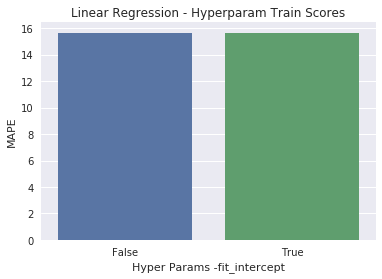

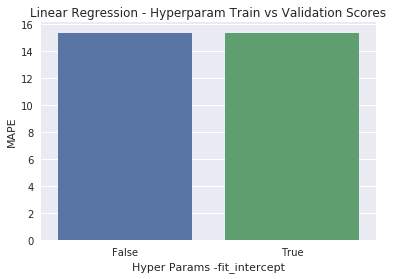

Best hyperparam value:  {'fit_intercept': True} Best Train Score:  15.6581 Best Validation Score:  15.3709
2019-06-28 09:24:07.344899  Hyperparam Tuning of Linear Regression completed


In [0]:
param_dict_lr = {'fit_intercept':[True, False]}
print(datetime.now() ,' Hyperparam Tuning of Linear Regression started')
hyp_tuned_info_lr = get_best_hyperparam_LinearRegression(param_dict_lr, X_train, y_train)
print(datetime.now() ,' Hyperparam Tuning of Linear Regression completed')

# separate out the fields
lr_best_hyp, lr_best_tr_mape, lr_best_val_mape, lr_best_tr_mse, lr_best_val_mse = hyp_tuned_info_lr

In [0]:
lr_regression = LinearRegression(fit_intercept=lr_best_hyp['fit_intercept'])

### Step 2. Train the model with best hyperparam value

In [0]:
print(datetime.now() ,' Training of Linear Regression started')
lr_regression.fit(X_train, y_train)
print(datetime.now() ,' Training of Linear Regression completed')

# save model to disk
pickle_out = open("./model/linear_regression.pkl","wb")
pickle.dump(lr_regression, pickle_out)
pickle_out.close()

2019-06-28 09:24:07.444273  Training of Linear Regression started
2019-06-28 09:24:07.740923  Training of Linear Regression completed


In [0]:
#load model from disk
pickle_in = open("./model/linear_regression.pkl","rb")
lr_regression = pickle.load(pickle_in)
pickle_in.close()

table_entry_train_lr = evaluate_ML_model(lr_regression, X_train, y_train)

 MSE:352.277400 MAPE:15.382900


### Step 3. Evaluate the model on test data 

In [0]:
table_entry_test_lr = evaluate_ML_model(lr_regression, X_test, y_test)

 MSE:372.147200 MAPE:14.930100


### B. Random Forest Regression Model

In [0]:
def get_best_hyperparam_RFRegressor(param_dict, X, y, random_search=False):
    
    # set the scoring function
    final_scorer = 'MAPE'
    
    # declare a scoring dictionary
    score_dict = {
        'MAPE': make_scorer(score_func=compute_mape, greater_is_better=False,
                                     needs_proba=False, needs_threshold=False),
        'MSE' : make_scorer(score_func=mean_squared_error, greater_is_better=False,
                                     needs_proba=False, needs_threshold=False)
    }
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'MAPE' : 'minimization',
        'MSE' : 'minimization'
    }
    
    # Time Series split
    cv_data = TimeSeriesSplit(n_splits=3)
        
     
    # declare model
    model = RandomForestRegressor()
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        # extract individual fiedls
        x_vals = grid_info_df[param_field_list[0]].tolist()
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('RF Regression - Hyperparam Train v/s Validation Scores')
        plt.show()
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('RF Regressor - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('RF Regressor - Hyperparams Scores - Validation')
        plt.show()
    
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    best_mse_train = best_hyperparam_record['mean_train_MSE']
    best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score, 
                 best_mse_train, best_mse_validation)
    
    
    return ret_tuple

### Step 1. Find the best hyperparm values

2019-06-28 09:24:08.026178  Hyperparam tuning of RF started


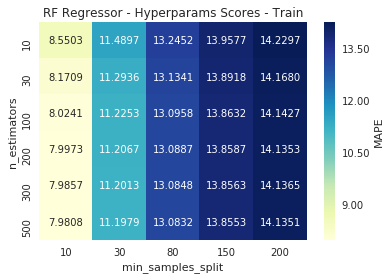

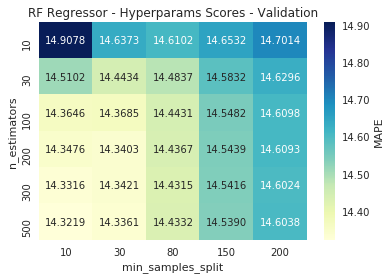

Best hyperparam value:  {'min_samples_split': 10, 'n_estimators': 500} Best Train Score:  7.9807999999999995 Best Validation Score:  14.3219
2019-06-28 11:16:19.436390  Hyperparam tuning of RF completed


In [0]:
param_dict_rf = {'n_estimators':[10, 30, 100, 200, 300, 500], 
                 'min_samples_split':[10, 30, 80, 150, 200]}

print(datetime.now() ,' Hyperparam tuning of RF started')
hyp_tuned_info_rf = get_best_hyperparam_RFRegressor(param_dict_rf, X_train, y_train)
print(datetime.now() ,' Hyperparam tuning of RF completed')

# separate out the fields
rf_best_hyp, rf_best_tr_mape, rf_best_val_mape, rf_best_tr_mse, rf_best_val_mse = hyp_tuned_info_rf

In [0]:
rf_reg = RandomForestRegressor(n_estimators=rf_best_hyp['n_estimators'], 
                               min_samples_split=rf_best_hyp['min_samples_split'])

### Step 2. Train the model with best hyperparam value

In [0]:
print(datetime.now() ,' Trainin of RF started')
rf_reg.fit(X_train, y_train)
print(datetime.now() ,' Training of RF completed')

# save model to disk
pickle_out = open("./model/rf_regression.pkl","wb")
pickle.dump(rf_reg, pickle_out)
pickle_out.close()

2019-06-28 11:16:21.679301  Trainin of RF started
2019-06-28 11:34:57.017125  Training of RF completed


In [0]:
#load model from disk
pickle_in = open("./model/rf_regression.pkl","rb")
rf_reg = pickle.load(pickle_in)
pickle_in.close()

table_entry_train_rf = evaluate_ML_model(rf_reg, X_train, y_train)

 MSE:92.915400 MAPE:7.748700


### Step 3. Evaluate the model on test data 

In [0]:
table_entry_test_rf = evaluate_ML_model(rf_reg, X_test, y_test)

 MSE:320.617000 MAPE:13.699300


### C. XGB Regression Model

In [0]:
def get_best_hyperparam_XGBRegressor(param_dict, X, y, random_search=False):
    
    # set the scoring function
    final_scorer = 'MAPE'
    
    # declare a scoring dictionary
    score_dict = {
        'MAPE': make_scorer(score_func=compute_mape, greater_is_better=False,
                                     needs_proba=False, needs_threshold=False),
        'MSE' : make_scorer(score_func=mean_squared_error, greater_is_better=False,
                                     needs_proba=False, needs_threshold=False)
    }
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'MAPE' : 'minimization',
        'MSE' : 'minimization'
    }
    
    # Time Series split
    cv_data = TimeSeriesSplit(n_splits=3)
    
    # =========================================================================================
        
     
    # declare model
    model = XGBRegressor()
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        # extract individual fiedls
        x_vals = grid_info_df[param_field_list[0]].tolist()
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('XGB Regression - Hyperparam Train v/s Validation Scores')
        plt.show()
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('XGB Regression - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('XGB Regression - Hyperparams Scores - Validation')
        plt.show()
    
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    best_mse_train = best_hyperparam_record['mean_train_MSE']
    best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score, 
                 best_mse_train, best_mse_validation)
    
    
    return ret_tuple

### Step 1. Find the best hyperparm values

2019-06-28 11:36:04.549515  Hyperparam Tuning of XGB started


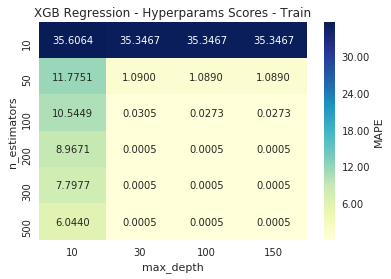

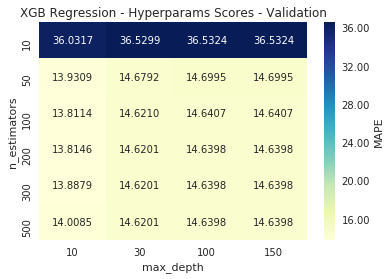

Best hyperparam value:  {'max_depth': 10, 'n_estimators': 100} Best Train Score:  10.544933333333333 Best Validation Score:  13.811433333333333
2019-06-28 14:22:43.548380  Hyperparam Tuning of XGB completed


In [0]:
param_dict_xgb = {'n_estimators':[10, 50, 100, 200, 300, 500], 
                  'max_depth':[10, 30, 100, 150]}

print(datetime.now() ,' Hyperparam Tuning of XGB started')
hyp_tuned_info_xgb = get_best_hyperparam_XGBRegressor(param_dict_xgb, X_train, y_train)
print(datetime.now() ,' Hyperparam Tuning of XGB completed')

# separate out the fields
xgb_best_hyp, xgb_best_tr_mape, xgb_best_val_mape, xgb_best_tr_mse, xgb_best_val_mse = hyp_tuned_info_xgb

In [0]:
xgb_reg = XGBRegressor(n_estimators=xgb_best_hyp['n_estimators'], 
                       max_depth=xgb_best_hyp['max_depth'])

### Step 2. Train the model with best hyperparam value

In [0]:
print(datetime.now() ,' Training of XGB started')
xgb_reg.fit(X_train, y_train)
print(datetime.now() ,' Training of XGB completed')

# save model to disk
pickle_out = open("./model/xgb_regression.pkl","wb")
pickle.dump(xgb_reg, pickle_out)
pickle_out.close()

2019-06-28 14:22:44.893562  Training of XGB started
2019-06-28 14:23:50.032242  Training of XGB completed


In [0]:
#load model from disk
pickle_in = open("./model/xgb_regression.pkl","rb")
xgb_reg = pickle.load(pickle_in)
pickle_in.close()

table_entry_train_xgb = evaluate_ML_model(xgb_reg, X_train, y_train)

 MSE:187.439600 MAPE:11.494100


### Step 3. Evaluate the model on test data 

In [0]:
table_entry_test_xgb = evaluate_ML_model(xgb_reg, X_test, y_test)

 MSE:297.925000 MAPE:13.204100


### Results Summary

In [0]:
pretty_table = PrettyTable()
pretty_table.title = 'Model Performance'
pretty_table.field_names = ['Model', 'HyperParam', 
                            'Train MSE', 'Train MAPE', 'Test MSE', 'Test MAPE']


###########################################################################
# add entry to the table
ratio_df_SMA_tr_mse = ratio_df_test_metrics['SMA_MSE']
ratio_df_SMA_tr_mape = ratio_df_test_metrics['SMA_MAPE']

ratio_df_WMA_tr_mse = ratio_df_test_metrics['WMA_MSE']
ratio_df_WMA_tr_mape = ratio_df_test_metrics['WMA_MAPE']

ratio_df_EWMA_tr_mse = ratio_df_test_metrics['EWMA_MSE']
ratio_df_EWMA_tr_mape = ratio_df_test_metrics['EWMA_MAPE']



# add entry to the table
ratio_df_SMA_ts_mse = ratio_df_test_metrics['SMA_MSE']
ratio_df_SMA_ts_mape = ratio_df_test_metrics['SMA_MAPE']

ratio_df_WMA_ts_mse = ratio_df_test_metrics['WMA_MSE']
ratio_df_WMA_ts_mape = ratio_df_test_metrics['WMA_MAPE']

ratio_df_EWMA_ts_mse = ratio_df_test_metrics['EWMA_MSE']
ratio_df_EWMA_ts_mape = ratio_df_test_metrics['EWMA_MAPE']


##########################################################################

# add entry to the table
df_2016_SMA_tr_mse = df_2016_train_metrics['SMA_MSE']
df_2016_SMA_tr_mape = df_2016_train_metrics['SMA_MAPE']

df_2016_WMA_tr_mse = df_2016_train_metrics['WMA_MSE']
df_2016_WMA_tr_mape = df_2016_train_metrics['WMA_MAPE']

df_2016_EWMA_tr_mse = df_2016_train_metrics['EWMA_MSE']
df_2016_EWMA_tr_mape = df_2016_train_metrics['EWMA_MAPE']



# add entry to the table
df_2016_SMA_ts_mse = df_2016_test_metrics['SMA_MSE']
df_2016_SMA_ts_mape = df_2016_test_metrics['SMA_MAPE']

df_2016_WMA_ts_mse = df_2016_test_metrics['WMA_MSE']
df_2016_WMA_ts_mape = df_2016_test_metrics['WMA_MAPE']

df_2016_EWMA_ts_mse = df_2016_test_metrics['EWMA_MSE']
df_2016_EWMA_ts_mape = df_2016_test_metrics['EWMA_MAPE']

###########################################################################

# 1) Ration Model
pretty_table.add_row(['Simple-MA-Rations', 'Window_Size :' + str(ratio_sim_best_window),
                      ratio_df_SMA_tr_mse, ratio_df_SMA_tr_mape, ratio_df_SMA_ts_mse, 
                      ratio_df_SMA_ts_mape])
pretty_table.add_row(['Weighted-MA-Rations', 'Window_Size :' + str(ratio_weight_best_window),
                      ratio_df_WMA_tr_mse, ratio_df_WMA_tr_mape, ratio_df_WMA_ts_mse, 
                      ratio_df_WMA_ts_mape])
pretty_table.add_row(['Exp_Weighted_MA-Rations', 'Alpha :' + str(ratio_exp_best_alpha), 
                      ratio_df_EWMA_tr_mse, ratio_df_EWMA_tr_mape, ratio_df_EWMA_ts_mse, 
                      ratio_df_EWMA_ts_mape])

# 2) only 2016 data model
pretty_table.add_row(['Simple-MA', 'Window_Size :' + str(sim_best_window), 
                      df_2016_SMA_tr_mse, df_2016_SMA_tr_mape, df_2016_SMA_ts_mse, 
                      df_2016_SMA_ts_mape])
pretty_table.add_row(['Weighted-MA', 'Window_Size :' + str(weight_best_window), 
                      df_2016_WMA_tr_mse, df_2016_WMA_tr_mape, df_2016_WMA_ts_mse, 
                      df_2016_WMA_ts_mape])
pretty_table.add_row(['Exp_Weighted_MA', 'Alpha :' + str(exp_best_alpha),
                      df_2016_EWMA_tr_mse, df_2016_EWMA_tr_mape, df_2016_EWMA_ts_mse, 
                      df_2016_EWMA_ts_mape])


###################### ML Models ######################################
# extract individual table entry fields for regression model
table_entry_lr = list(table_entry_train_lr + table_entry_test_lr)
table_entry_rf = list(table_entry_train_rf + table_entry_test_rf)
table_entry_xgb = list(table_entry_train_xgb + table_entry_test_xgb)

lr_best_hyp = '\n'.join(str(lr_best_hyp).split(','))
rf_best_hyp = '\n'.join(str(rf_best_hyp).split(','))
xgb_best_hyp = '\n'.join(str(xgb_best_hyp).split(','))

# add entry to the table
pretty_table.add_row(['Linear Regression', lr_best_hyp] + table_entry_lr)
pretty_table.add_row(['RF Regression', rf_best_hyp] + table_entry_rf)
pretty_table.add_row(['XGB Regression', xgb_best_hyp] + table_entry_xgb)


# pretty table print
print(pretty_table)
print(datetime.now() ,' Done !!!')

+-------------------------------------------------------------------------------------------------------+
|                                           Model Performance                                           |
+-------------------------+--------------------------+------------+------------+------------+-----------+
|          Model          |        HyperParam        | Train MSE  | Train MAPE |  Test MSE  | Test MAPE |
+-------------------------+--------------------------+------------+------------+------------+-----------+
|    Simple-MA-Rations    |      Window_Size :3      | 14189.4918 |  98.7984   | 14189.4918 |  98.7984  |
|   Weighted-MA-Rations   |      Window_Size :1      | 14188.2217 |  98.8209   | 14188.2217 |  98.8209  |
| Exp_Weighted_MA-Rations |        Alpha :0.4        | 14189.969  |  98.7954   | 14189.969  |  98.7954  |
|        Simple-MA        |      Window_Size :2      |  379.2613  |  15.7021   |  396.5671  |  15.3125  |
|       Weighted-MA       |      Window_Size :

# Proceudre Summary

<ul>
<li> Used both 2015, 2016 data to build the basic time series models such as simple moving average,
     weighted moving average and exponentially weighted moving average . </li>
<li> Used only 2016 data for building the ML models (Linear Regesssion, RF model & XGB) </li>
<li> Hyperparam is tuned for all models using valiation data set </li>
<li> Fourier featues are incorporated to the dataset . Both amplitude and frequency are considered </li>
<li> The time slot of a day (0-143) is also used as a feature </li>
<li> Training, Testing is done by partitioning the dataset based on time steps (time series split)</li>
</ul>

# Conclusion

<ul>
<li> The performace of classic time series ration model is not great when compared
     to the previous data model. The MAPE value is quite high 97%, where as the same year 
     data model showed around 15% MAPE</li>
<li> The best ML model obtained is the XGB regressor with 13.20 % MAPE </li>
<li> Random forest model showd a tendency to overfit as there is a significant difference between
     train, test MAPE values (about 6% MAPE)</li>
<li> Even though the dataset is partiioned based on time stamp, the models used are not capable of 
     handling time series data </li>
<li> Inorder to redce the MAPE value further proper time series models such as LSTM, GRU can be tried </li>
</ul>